# <center> **Grupo más Cercano (Nearest Group)**

# Similitud


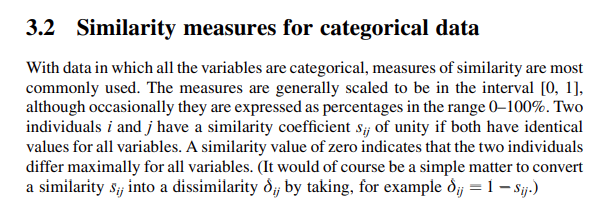


**Referencia:**

- [Brian S. Everitt, et al., Clueter Analysis, 5th edition, p.46](https://cicerocq.files.wordpress.com/2019/05/cluster-analysis_5ed_everitt.pdf)

**Summary:**

- 0 : Un coeficiente de similitud de 0 significa que dos conjuntos, i y j, son distintos, es decir, que tienen una diferencia máxima.
- 1 : Un coeficiente de similitud de 1 significa que dos conjuntos, i y j, son idénticos.   

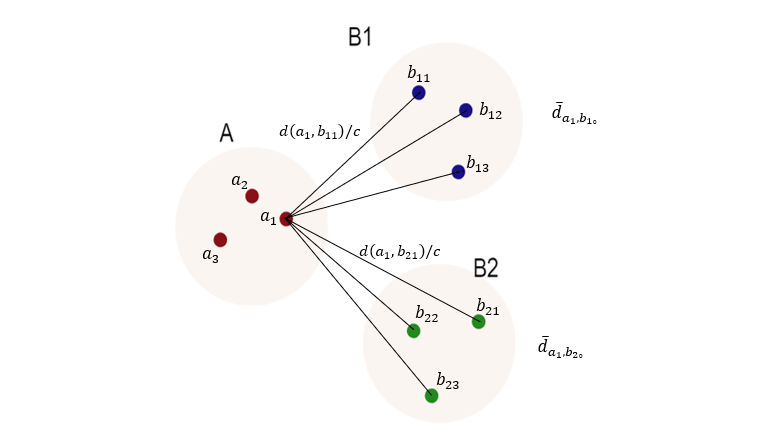

**Distancie en una superficie esférica**



Para calcular la distancia se empleó la fórmula de [Haversine](https://en.wikipedia.org/wiki/Haversine_formula)

$d = R \times c$

$c = 2 \times arctan2(\sqrt{a},\sqrt{1-a})$

y

$a= sin^2(\frac{\Delta \phi^2 }{2}) + \cos(\phi_1)\times \cos(\phi_2) \times sin^2(\frac{\Delta \lambda }{2})$

donde:

- $\phi$ : latitud
- $\lambda$ : longitud
- d : Radio medio en km

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from statistics import mode
from geopy.distance import geodesic
from statistics import mean
import time
sns.set()

**Distancia euclideana: Tijuana a bacalar**

In [3]:
def euclidean_dist(x,y):
  dist = np.sqrt(np.sum([(a-b)**2 for a,b in zip(x,y)]))
  return dist

**Distancia a centroides Trigo**

In [4]:
b = [27.09, -109.12] # beneficiarios
x = [18.92, -98.55] # marginación
y = [20.42, -99.20] # precio

d1, d2 = geodesic(b, x).km, geodesic(b, y).km
print('Centroides: ', [d1,d2])

Centroides:  [1410.4286503333296, 1251.4714786045095]


**Distancia a centroides Maíz**

In [5]:
b = [19.93, -100.08] # beneficiarios
x = [18.48, -97.47] # marginación
y = [20.44, -99.95] # precio

d1, d2 = geodesic(b, x).km, geodesic(b, y).km
print('Centroides: ', [d1,d2])

Centroides:  [317.94899021888403, 58.072453918627325]


**versión2**

In [107]:
#-------------------------------------------------------------------------------
#                               Nearest Group
#-------------------------------------------------------------------------------
class NearestGroup:


  def __init__(self, metric='euclidean', c=None):
    '''
    Inputs :
      base : muestra de referencia arreglo n x m. m filas (latitud y longitud)
      groups : diccionario con k muestras de comparación
    '''
    # grupos de comparación
    self.samples = None
    # nombre de cada grupo de comparación
    self.names = None
    self.metric = metric
    self.c = c
    self.coeff = None
    self.means = None
    self.base_shape = None
    self.samples_shape = None

  # Métricas:
  def distance(self, x, y, type='euclidean'):
    # euclidean distance
    if type=='euclidean':
      dist = np.sqrt(np.sum([(a-b)**2 for a,b in zip(x,y)]))
    # geodesic distance
    elif type == 'geodesic':
      dist = geodesic(x, y).km
    else:
      raise ValueError('Type of distance is not available')
    return dist

  # función para calcular distancias de los puntos (muestra base) a puntos de otra muestra.
  def _dist_between_two_groups(self, sample_1, sample_2, d_norm=True):

    '''
    Function to estimate distance between two groups

    inputs:
      sample1: muestra con n1 filas y m columnas : latitud y longitud
      sample2: muestra con n2 filas y m columnas : latitud y longitud

    Outputs:
      d     : list of distaces between two groups
      means : average distances
      coeff : similarity coefficient
    '''
    d = []
    dnorm = []
    min = []
    mean = []
    dnorm_mean = []
    coeff = []
    for x1 in sample_1:
      dist = []
      for x2 in sample_2:
        dist_i = self.distance(x1,x2, type=self.metric)
        dist.append(dist_i)
      d.append(dist)
      # minimo
      dmin = np.min(dist)
      min.append(dmin)
      # máximo
      # dmax = np.max(dist)
      # max.append(dmax)
      # promedio
      dmean = np.mean(dist)
      mean.append(dmean)
      # distancias normalizadas
      if d_norm == True:
        return d

      d_norm = [dij/self.c for dij in dist]
      dnorm.append(d_norm)
      # mean dnorm
      d_norm_mean = np.mean(d_norm)
      dnorm_mean.append(d_norm_mean)
      # coeficiente
    sh = [1 if m==0 else 1-d for m,d in zip(min, dnorm_mean)]
    # coeff
    coeff = np.mean(sh)
    means = np.mean(mean)

    return d, means, coeff

  # funtion to get the maximum distance
  def get_max(self, base, groups):

    '''
    This function returns the maximum distance between one group to the rest groups
    '''
    # extract samples
    samples = []
    self.names = []
    for key, val in groups.items():
      samples.append(val)
      self.names.append(key)

    # list of k groups
    list_samples = samples
    # distances per group
    dg = []
    # coefficients per group
    coeffg = []
    # means per group
    meansg = []
    # loop to save distances per group
    for k in range(len(list_samples)):
      g_comparacion = list_samples[k]
      d = self._dist_between_two_groups(base, g_comparacion, d_norm=True)
      dg.append(d)

    return max([max(max(g)) for g in dg])

  # funtion to get the similarity coefficient
  def fit(self, base, groups):
    '''
    Inputs :
      base   : muestra de referencia arreglo n x m. m filas (latitud y longitud)
      groups : diccionario con k muestras de comparación

    Outputs :
       dg     : list of distaces for each group
      meansg  : average distances for each group
      coeffg  : similarity coefficient each group
    '''
    # validación
    self.base_shape = np.array(base).shape[0]
    self.samples_shape = []
    samples = []
    self.names = []
    for key, val in groups.items():
      samples.append(val)
      self.samples_shape.append(np.array(val).shape[0])
      self.names.append(key)

    # validación de la muestra base
    if isinstance(base, list):
      pass
    else:
      raise TypeError("La muestra base debe ser una lista")
    # validación de las muestras de comparación
    for sample in samples:
      if isinstance(sample, list):
        pass
      else:
        raise TypeError("Las muestras de comparación deben ser listas")
    # condition for constant c
    if self.c is None:
      self.c = self.get_max(base, groups)
    else:
      self.c = float(self.c)

    # list of groups
    list_samples = samples
    dg = []
    coeffg = []
    meansg = []
    # loop to iterate all the groups
    for k in range(len(list_samples)):
      g_comparacion = list_samples[k]
      d, means, coeff = self._dist_between_two_groups(base, g_comparacion, d_norm=False)
      dg.append(d)
      coeffg.append(coeff)
      meansg.append(means)
    # instance atributes
    self.coeff = coeffg
    self.means = meansg

    return dg, meansg, coeffg

  # Function to estimate distance to centroids
  def fit2(self, base, groups):
    '''
    Inputs :
      base : muestra de referencia arreglo n x m. m filas (latitud y longitud)
      groups : diccionario con k muestras de comparación
    '''

    samples = []
    names = []
    for key, val in groups.items():
      samples.append(val)
      names.append(key)
    # validation
    if isinstance(base, list):
      pass
    else:
      raise TypeError("La muestra base debe ser una lista")
    # validation
    for sample in samples:
      if isinstance(sample, list):
        pass
      else:
        raise TypeError("Las muestras de comparación deben ser listas")

    list_samples = samples.copy()
    # centroide for each comparison group
    centrosx = [x[0] for x in base]
    centrosy = [y[1] for y in base]
    base_centroidex = np.mean(centrosx)
    base_centroidey = np.mean(centrosy)
    base_centroide = [base_centroidex, base_centroidey]
    # list to save centroids
    sample_centroides = []
    dist_centroides_list = []
    for sample in list_samples:
      sample_centrosx = [x[0] for x in sample]
      sample_centrosy = [y[1] for y in sample]
      sample_centroidex = np.mean(sample_centrosx)
      sample_centroidey = np.mean(sample_centrosy)
      sample_centroide = [sample_centroidex, sample_centroidey]
      sample_centroides.append([sample_centroidex, sample_centroidey])
      # distance to centroids
      dist = self.distance(base_centroide, sample_centroide, type=self.metric)
      dist_centroides_list.append(dist)

    return np.round(dist_centroides_list,4)

  # funtion to return summary of estimations
  def summary(self):
    # results
    result_min = self.names[pd.Series(self.coeff).idxmax()]
    result_means =  np.round(self.means,4)
    result_coeff = np.round(self.coeff,4)
    # summary
    head = f"{'-'*120}- \n-{' '*55} Summary{' '*55} -\n{'-'*120}- \n"
    intro = f" Base (Obs): \t \t {self.base_shape} \n Groups (Obs): \t \t {self.samples_shape} \n \n"
    body = f" Nearest Group: \t {result_min} \n Avg. Distance: \t {result_means} \n Coeff. Similitud: \t {result_coeff} \n"
    pie = f"{'-'*120}"
    return print(head + intro + body + pie)


# **Ejemplo 1: Datos sintéticos con 2 grupos**

Primero generamos un conjunto de datos con la función make_blobs, comenzamos con **3 grupos**.

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set()
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.datasets import make_classification, make_blobs

random.seed(23456798)

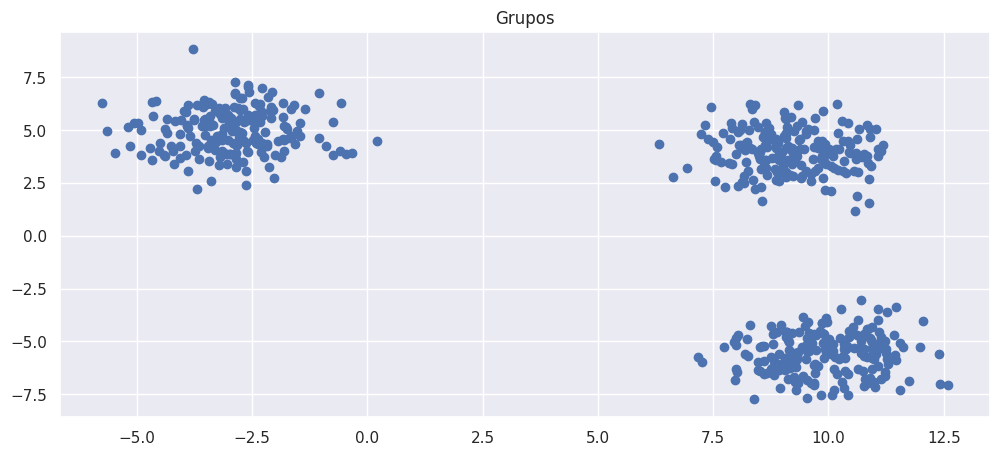

In [112]:
X, y = make_blobs(n_samples=600,centers=3, random_state=24)
#X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=4)
colors = ['blue', 'red', 'green']
plt.figure(figsize=(12,5))
plt.title('Grupos')
plt.scatter(X[:, 0], X[:, 1])
plt.show()

Para separar el conjunto de datos por cada grupos, empleamos el algoritmo de k-means con $k=3$ para realizar dicha tarea.

In [113]:
from sklearn.cluster import KMeans

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[0 1 2]


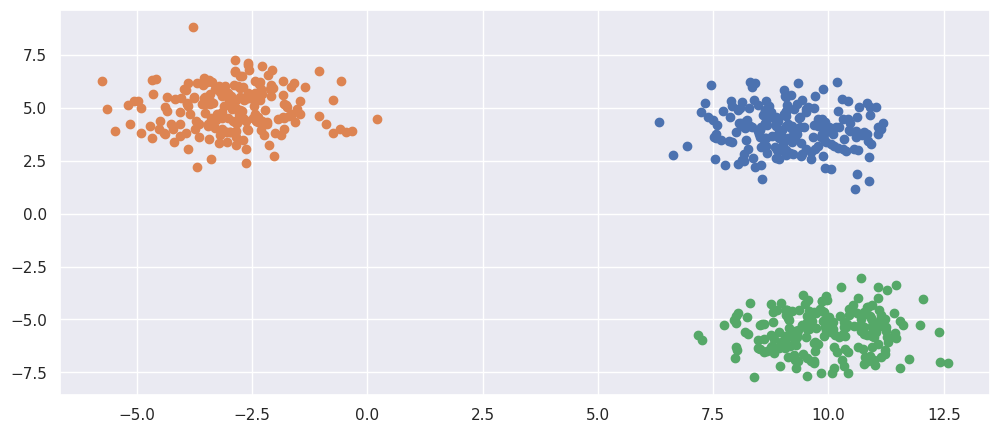

In [114]:
modelo = KMeans(n_clusters=3)

modelo.fit(X)
# retorna las etiquetas
y_clusters = modelo.predict(X)
# retorna número de clusters
clusters = np.unique(y_clusters)
print(clusters)
plt.figure(figsize=(12,5))
for cluster in clusters:
    fila = np.where(y_clusters == cluster)
    plt.scatter(X[fila, 0], X[fila, 1])

plt.show()

Ahora formamos un dataframe con los datos generados y con la etiqueta del cluster correspondiente.

In [115]:
# base
base = pd.DataFrame(X).rename({0:'Lat',1:'Lon'}, axis=1)
base['cluster'] = y_clusters
base.head()

,Lat,Lon,cluster
0,-3.640627,3.649409,1
1,-1.826795,4.584232,1
2,10.428592,4.473935,0
3,-3.880441,3.061071,1
4,-3.403694,5.647732,1


Separamos el dataframe formado por cada grupo correspondiente, y graficamos.

In [116]:
sample1 = base[base['cluster'] == 0].drop('cluster', axis=1).reset_index(drop=True)
sample2 = base[base['cluster'] == 1].drop('cluster', axis=1).reset_index(drop=True)
sample3 = base[base['cluster'] == 2].drop('cluster', axis=1).reset_index(drop=True)

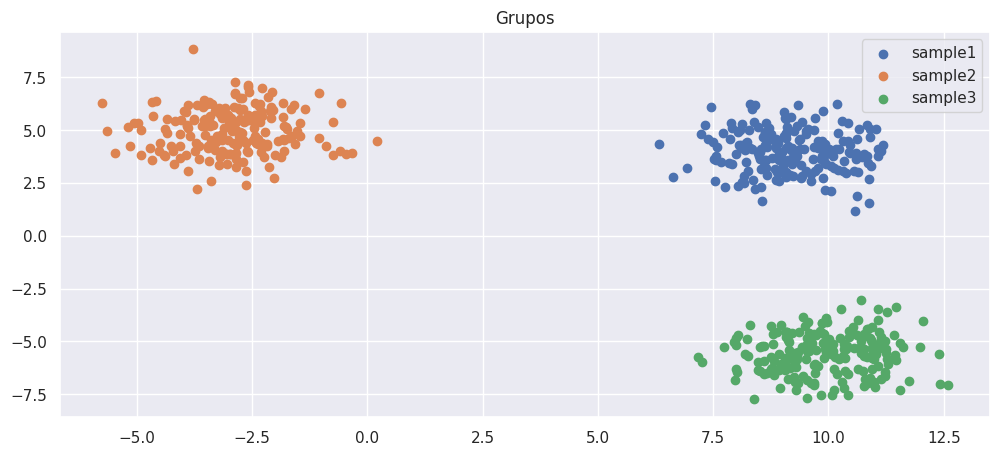

In [117]:
plt.figure(figsize=(12,5))
plt.scatter(sample1['Lat'], sample1['Lon'], label='sample1')
plt.scatter(sample2['Lat'], sample2['Lon'], label='sample2')
plt.scatter(sample3['Lat'], sample3['Lon'], label='sample3')
plt.title('Grupos')
plt.legend()
plt.show()

Finalmente, para aplicar el algoritmo, por cada observación de cada muestra generamos tuplas (lat, y lon).

In [118]:
samp1 = [[val1, val2] for val1, val2 in zip(sample1['Lat'], sample1['Lon'])]
samp2 = [[val1, val2] for val1, val2 in zip(sample2['Lat'], sample2['Lon'])]
samp3 = [[val1, val2] for val1, val2 in zip(sample3['Lat'], sample3['Lon'])]

In [119]:
print(np.array(samp1).shape)
print(np.array(samp2).shape)
print(np.array(samp3).shape)

(200, 2)
(200, 2)
(200, 2)


In [120]:
# valores
base = samp1
grupos = {'sample1': samp2,
          'sample2':samp3,
          'sample3':samp1}

In [121]:
# Ejecutamos
nearest_group = NearestGroup(metric='euclidean')
d, means, coeff = nearest_group.fit(base, grupos)
nearest_group.summary()

------------------------------------------------------------------------------------------------------------------------- 
-                                                        Summary                                                        -
------------------------------------------------------------------------------------------------------------------------- 
 Base (Obs): 	 	 200 
 Groups (Obs): 	 	 [200, 200, 200] 
 
 Nearest Group: 	 sample3 
 Avg. Distance: 	 [12.2486  9.7044  1.7389] 
 Coeff. Similitud: 	 [0.2474 0.4037 1.    ] 
------------------------------------------------------------------------------------------------------------------------


De lo anterios observamos que el conjunto base tiene 200 observaciones, los grupos de comparación 200 observaciones para cada uno. El grupo más cercano corresponde a la muestra 3, la cual es consistente con la menor distancia promedsio y mediante el mayor coeficiente de similitud.  

# **Ejemplo 2: Datos sintéticos con 3 grupos**

Primero generamos un conjunto de datos con la función make_blobs, comenzamos con **5 grupos**.

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set()
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.datasets import make_classification, make_blobs

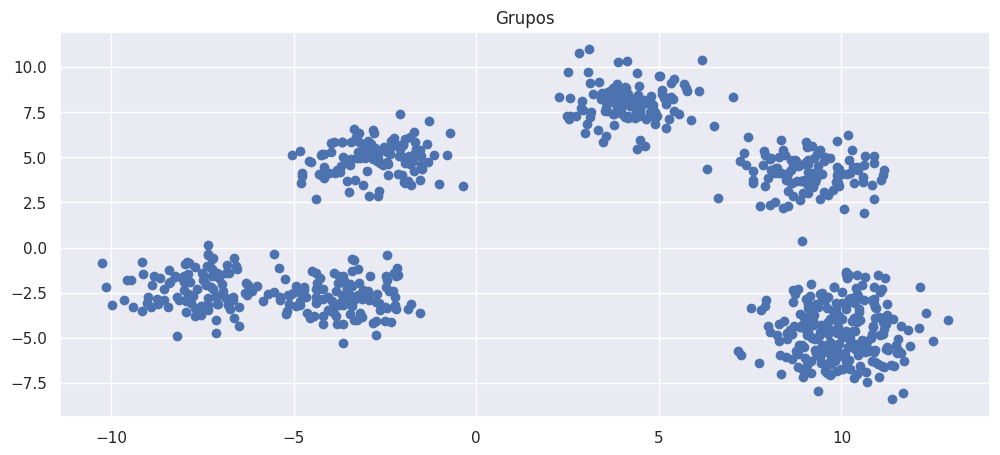

In [123]:
X, y = make_blobs(n_samples=800,centers=7, random_state=24)
colors = ['blue', 'red', 'green']
plt.figure(figsize=(12,5))
plt.title('Grupos')
plt.scatter(X[:, 0], X[:, 1])
plt.show()

Para separar el conjunto de datos por cada grupos, empleamos el algoritmo de k-means con $k=5$ para realizar dicha tarea.

In [124]:
from sklearn.cluster import KMeans

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[0 1 2 3 4]


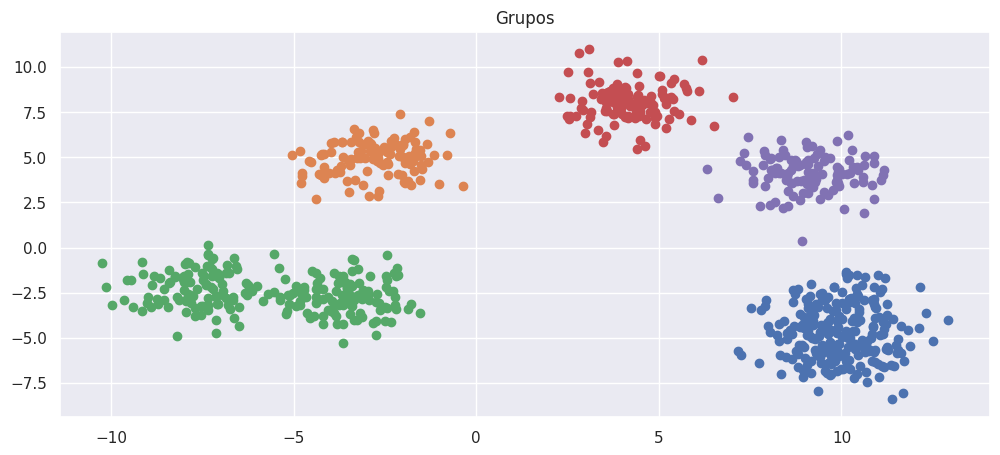

In [125]:
modelo = KMeans(n_clusters=5)

modelo.fit(X)
# retorna las etiquetas
y_clusters = modelo.predict(X)
# retorna número de clusters
clusters = np.unique(y_clusters)
print(clusters)
plt.figure(figsize=(12,5))
for cluster in clusters:
    fila = np.where(y_clusters == cluster)
    plt.scatter(X[fila, 0], X[fila, 1])
plt.title('Grupos')
plt.show()

Ahora formamos un dataframe con los datos generados y con la etiqueta del cluster correspondiente.

In [126]:
# base
base = pd.DataFrame(X).rename({0:'Lat',1:'Lon'}, axis=1)
base['cluster'] = y_clusters
base.head()

,Lat,Lon,cluster
0,11.881873,-5.478030,0
1,-0.800726,5.132793,1
2,-7.100404,-1.560874,2
3,10.386248,-2.227496,0
4,10.290632,5.417513,4


Separamos el dataframe formado por cada grupo correspondiente, y graficamos.

In [127]:
sample1 = base[base['cluster'] == 0].drop('cluster', axis=1).reset_index(drop=True)
sample2 = base[base['cluster'] == 1].drop('cluster', axis=1).reset_index(drop=True)
sample3 = base[base['cluster'] == 2].drop('cluster', axis=1).reset_index(drop=True)
sample4 = base[base['cluster'] == 3].drop('cluster', axis=1).reset_index(drop=True)
sample5 = base[base['cluster'] == 4].drop('cluster', axis=1).reset_index(drop=True)

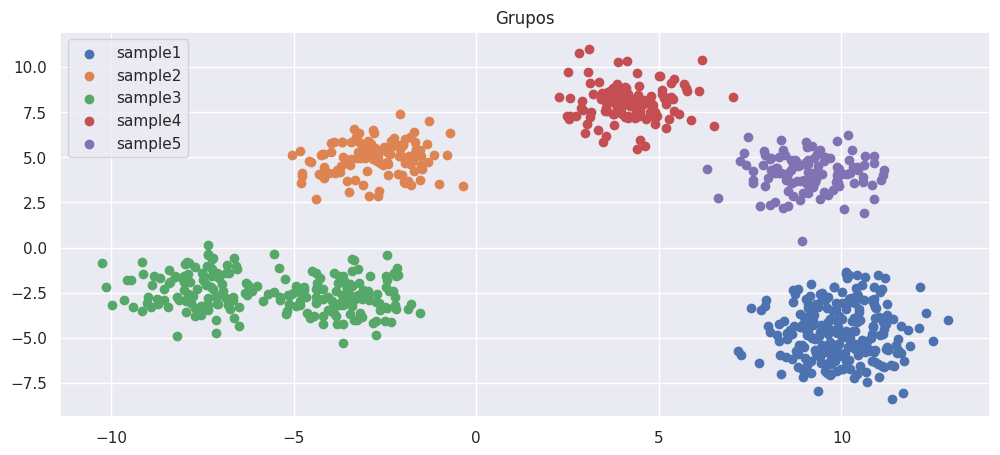

In [128]:
plt.figure(figsize=(12,5))
plt.scatter(sample1['Lat'], sample1['Lon'], label='sample1')
plt.scatter(sample2['Lat'], sample2['Lon'], label='sample2')
plt.scatter(sample3['Lat'], sample3['Lon'], label='sample3')
plt.scatter(sample4['Lat'], sample4['Lon'], label='sample4')
plt.scatter(sample5['Lat'], sample5['Lon'], label='sample5')
plt.title('Grupos')
plt.legend()
plt.show()

Finalmente, para aplicar el algoritmo, por cada observación generamos la tupla (lat, lon).

In [129]:
samp1 = [[val1, val2] for val1, val2 in zip(sample1['Lat'], sample1['Lon'])]
samp2 = [[val1, val2] for val1, val2 in zip(sample2['Lat'], sample2['Lon'])]
samp3 = [[val1, val2] for val1, val2 in zip(sample3['Lat'], sample3['Lon'])]
samp4 = [[val1, val2] for val1, val2 in zip(sample4['Lat'], sample4['Lon'])]
samp5 = [[val1, val2] for val1, val2 in zip(sample5['Lat'], sample5['Lon'])]

y aplicamos el algorítmo

In [130]:
# Muestra base
base = samp1

# Muestras de comparación
grupos = {'sample2':samp2,
          'sample3':samp3,
          'sample4':samp4,
          'sample5':samp5,
          'sample6':samp1}

Imprimimos resultados

In [131]:
# Ejecutamos
nearest_group = NearestGroup(metric='euclidean')
d, means, coeff = nearest_group.fit(base, grupos)
nearest_group.summary()

------------------------------------------------------------------------------------------------------------------------- 
-                                                        Summary                                                        -
------------------------------------------------------------------------------------------------------------------------- 
 Base (Obs): 	 	 228 
 Groups (Obs): 	 	 [114, 228, 114, 116, 228] 
 
 Nearest Group: 	 sample6 
 Avg. Distance: 	 [16.0025 15.7807 14.0016  8.9252  2.2864] 
 Coeff. Similitud: 	 [0.2919 0.3017 0.3805 0.6051 1.    ] 
------------------------------------------------------------------------------------------------------------------------


Primero, el grupo base contiene 228 observaciones, mientras que la muestra 2 (sample2) contiene 114, la muestra 3 (sample3) 228, la muestra 4 (sample4) 114, muestra 5 (sample5) 116, muestra 6 (sample6) 228. El grupo más cercano corresponde a la muestra 6 (sample6). Gráficamente podemos corroborarlo, y al igual que el caso anterior, la distancia promedio y el coeficiente de similitud son consistente, es decir, a menor distancia o mayor coeficiente de similitud, la cercania entre los grupos es mayor.

# <center> **Datos de Beneficiarios y Escenarios**

Antes de comenzar con los ejemplos numéricos, vamos a determinar el parámetro $c$, es decir, la distancia que hay entre tijuana y bacalar, una vez calculado
el valor lo emplearemos al definir la clase $NearestGroup(metric, c)$, ya si no agregamos el parámetro $c$ por defecto la estimación se hace considerando la distancia máxima entre los puntos de beneficiarios al resto de puntos.

In [4]:
# latitud y longitud
tijuana = [18.6783, -88.3924]
bacalar = [32.5027, -117.0037]

# distancia euclideana
distancia = euclidean_dist(x=tijuana,y=bacalar)
distancia

31.77609987160161

**Casi 1: Maíz**

In [216]:
producto = 'Maíz'
anio = 2021

In [217]:
benef = pd.read_excel('PBeneficiarios_data_2021.xlsx')
print(benef.columns)
benef_filt = benef[benef['Anio']==anio]
benef_filt = benef_filt[benef_filt['Producto']==producto]
benef_filt = benef_filt[['LAT_DECIMAL','LON_DECIMAL']].dropna(axis=0)
benef_filt.head()

Index(['Anio', 'Producto', 'Edad', 'CVE_ENT', 'NOM_ENT', 'CVE_MUN', 'NOM_MUN',
       'CVE_LOC', 'NOM_LOC', 'EML', 'Ciclo Productivo',
       'Precio de garantía $ (Litro/Tonelada)', 'Precio referencia',
       'Volumen incentivado (Litros / Toneladas)', 'Monto de apoyo total $',
       'Tamaño del productor', 'IML', 'GML', 'IMM', 'GMM', 'LATITUD',
       'LONGITUD', 'LAT_DECIMAL', 'LON_DECIMAL'],
      dtype='object')


,LAT_DECIMAL,LON_DECIMAL
3632,20.334282,-101.638008
3633,20.375100,-101.698306
3634,20.303605,-101.812116
3635,20.219654,-101.794496
3638,20.646378,-101.520400


In [218]:
prod = pd.read_excel('TotalProductores2.xlsx')
prod_filt = prod[prod['Anio']==anio]
prod_filt = prod_filt[prod_filt['Producto']==producto]
prod_filt.head()

,Anio,Producto,CVE_ENT,NOM_ENT,CVE_MUN,NOM_MUN,TotalCosechada,TotalProductores,GM,IM,Escenario1,Escenario2,LAT_DECIMAL,LON_DECIMAL
554,2021,Maíz,15,México,91,Teoloyucan,57.0,22,Muy bajo,0.922150,NaN,4.160578e+09,19.75,-99.18
555,2021,Maíz,10,Durango,17,Ocampo,2798.0,115,Bajo,0.870007,NaN,4.154602e+09,26.44,-105.51
556,2021,Maíz,10,Durango,1,Canatlán,5108.0,209,Muy bajo,0.887781,NaN,4.138893e+09,24.53,-104.78
557,2021,Maíz,10,Durango,9,Guanaceví,1908.0,78,Medio,0.829850,NaN,4.107130e+09,25.93,-105.95
558,2021,Maíz,14,Jalisco,76,San Martín de Bolaños,701.0,19,Medio,0.835887,NaN,4.097426e+09,21.68,-103.81


In [ ]:
esc1 = prod_filt.dropna(subset=['Escenario1'])[['LAT_DECIMAL',	'LON_DECIMAL']]
esc2 = prod_filt.dropna(subset=['Escenario2'])[['LAT_DECIMAL',	'LON_DECIMAL']]

In [220]:
sample1 = benef_filt.copy().dropna()
print(sample1.shape)
sample2 = esc1.copy().dropna()
print(sample2.shape)
sample3 = esc2.copy().dropna()
print(sample3.shape)

(82357, 2)
(580, 2)
(271, 2)


In [149]:
# sample1.to_csv('georef_benef_maiz.csv')
# sample2.to_csv('georef_marginacion_maiz.csv')
# sample3.to_csv('georef_precio_maiz.csv')

In [221]:
samp1 = [[val1, val2] for val1, val2 in zip(sample1['LAT_DECIMAL'], sample1['LON_DECIMAL'])]
samp2 = [[val1, val2] for val1, val2 in zip(sample2['LAT_DECIMAL'], sample2['LON_DECIMAL'])]
samp3 = [[val1, val2] for val1, val2 in zip(sample3['LAT_DECIMAL'], sample3['LON_DECIMAL'])]

In [222]:
# Muestra base Maíz
base = samp1

# Muestras de comparación
grupos = {'Marginación':samp2,
          'Precio':samp3}

# Ejecutamos
start_time = time.time()
nearest_group = NearestGroup(metric='euclidean', c=31.776099)
d, means, coeff = nearest_group.fit(base, grupos)
nearest_group.summary()

------------------------------------------------------------------------------------------------------------------------- 
-                                                        Summary                                                        -
------------------------------------------------------------------------------------------------------------------------- 
 Base (Obs): 	 	 82357 
 Groups (Obs): 	 	 [580, 271] 
 
 Nearest Group: 	 Marginación 
 Avg. Distance: 	 [7.1954 7.6895] 
 Coeff. Similitud: 	 [0.7736 0.758 ] 
------------------------------------------------------------------------------------------------------------------------


El resultado anterior nos indica que el grupo más cercano, al grupo de beneficialrios, corresponde al criterio de marginación.

**Trigo**

In [140]:
producto = 'Trigo'
anio = 2021

In [141]:
benef = pd.read_excel('PBeneficiarios_data_2021.xlsx')

benef_filt = benef[benef['Anio']==anio]
benef_filt = benef_filt[benef_filt['Producto']==producto]
benef_filt = benef_filt[['LAT_DECIMAL','LON_DECIMAL']].dropna(axis=0)

benef_filt.head()

print(benef_filt.shape)
#benef_filt.to_csv('georef_beneficiarios_trigo.csv')

(10300, 2)


In [142]:
# Total productores
prod = pd.read_excel('TotalProductores2.xlsx')
prod_filt = prod[prod['Producto']==producto]
print(prod_filt.shape)

(482, 14)


In [143]:
esc1 = prod_filt.dropna(subset=['Escenario1'])[['LAT_DECIMAL',	'LON_DECIMAL']]
print(esc1.shape)
esc2 = prod_filt.dropna(subset=['Escenario2'])[['LAT_DECIMAL',	'LON_DECIMAL']]
print(esc2.shape)

(165, 2)
(90, 2)


In [ ]:
# save to csv
#esc1.to_csv('georef_marginación.csv')
#esc2.to_csv('georef_precio.csv')

In [144]:
sample1 = benef_filt.copy().dropna()
sample2 = esc1.copy().dropna()
sample3 = esc2.copy().dropna()

In [145]:
samp1 = [[val1, val2] for val1, val2 in zip(sample1['LAT_DECIMAL'], sample1['LON_DECIMAL'])]
samp2 = [[val1, val2] for val1, val2 in zip(sample2['LAT_DECIMAL'], sample2['LON_DECIMAL'])]
samp3 = [[val1, val2] for val1, val2 in zip(sample3['LAT_DECIMAL'], sample3['LON_DECIMAL'])]

- sample2 : Escenario2
- sample3 : Escenario3

In [146]:
# Muestra base Trigo
base = samp1

# Muestras de comparación
grupos = {'Marginación':samp2,
          'Precio':samp3}

# Ejecutamos
start_time = time.time()
nearest_group = NearestGroup(metric='euclidean', c=31.776099)
d, means, coeff = nearest_group.fit(base, grupos)
nearest_group.summary()

------------------------------------------------------------------------------------------------------------------------- 
-                                                        Summary                                                        -
------------------------------------------------------------------------------------------------------------------------- 
 Base (Obs): 	 	 10300 
 Groups (Obs): 	 	 [165, 90] 
 
 Nearest Group: 	 Precio 
 Avg. Distance: 	 [13.6275 12.2837] 
 Coeff. Similitud: 	 [0.5711 0.6134] 
------------------------------------------------------------------------------------------------------------------------


Para el caso del trigo, el grupo más cercano al grupo de beneficiarios corresponde al grupo generado con el criterio del precio.